In [ ]:
!mkdir -p dataset

In [ ]:
import os
def my_save_plots(title, xlabel, ylabel, save_name):
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if not os.path.exists("plots"):
        os.makedirs("plots")
    plt.savefig(f"plots/{save_name}.png", bbox_inches='tight')

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [ ]:
# train = pd.read_csv("dataset/train.csv")
# test = pd.read_csv("dataset/test.csv")

In [ ]:
# test.head()

In [ ]:
train = pd.read_csv("dataset/train.csv")
test = pd.read_csv("dataset/test.csv")

if not 'Transported' in test:
    test['Transported'] = False

original_test_passenger_id = test['PassengerId'].copy()

In [ ]:
def preprocess(train, test):
    df = pd.concat([train, test], sort=False).reset_index(drop=True)
    df[['Deck', 'Num', 'Side']] = df['Cabin'].str.split('/', expand=True)
    df.drop(columns=['Cabin', 'Name'], inplace=True)

    df["Num"] = pd.to_numeric(df["Num"], errors='coerce')
    df.Deck.fillna('U', inplace=True)
    df.Num.fillna(-1, inplace=True)
    df.Side.fillna('U', inplace=True)
    df.HomePlanet.fillna("U", inplace=True)
    df.Destination.fillna("U", inplace=True)

    df['Group'] = df['PassengerId'].str.split('_').str[0]
    group_sizes = df['Group'].value_counts()
    df['GroupSize'] = df['Group'].map(group_sizes)

    df['SpentMoney'] = (df[["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]].sum(axis=1) > 0).astype(int)

    df['SoloTraveler'] = (df['GroupSize'] == 1).astype(int)



    # Label encoding
    le_deck = LabelEncoder()
    le_side = LabelEncoder()
    df['Deck'] = le_deck.fit_transform(df['Deck'])
    df['Side'] = le_side.fit_transform(df['Side'])

    # One-hot encoding
    cols = ["CryoSleep", "VIP", "HomePlanet", "Destination"]
    for col in cols:
      df = pd.concat([df.drop(columns=col),
                      pd.get_dummies(df[col], prefix=col)], axis=1)

    # Impute numerical columns
    numerical_col = df.select_dtypes(include=['int64', 'float64']).columns
    cols_with_nulls = [col for col in numerical_col if df[col].isnull().any()]

    imputer = KNNImputer(n_neighbors=5)
    df[cols_with_nulls] = imputer.fit_transform(df[cols_with_nulls])

    #feature engineering:
    amt = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]
    total_amt = 0
    for i in amt:
        total_amt += df[i]
    df['TotalAmt'] = total_amt

    df_train = df[: len(train)]
    df_test = df[len(df_train):]

    df_test.drop('Transported', axis = 1, inplace=True)
    df_train.drop('PassengerId', axis=1, inplace=True)
    df_test.drop('PassengerId', axis=1, inplace=True)




    return df_train, df_test


In [ ]:
df_train, df_test = preprocess(train, test)
# df_train.head()

/tmp/ipython-input-3128862650.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.Deck.fillna('U', inplace=True)
/tmp/ipython-input-3128862650.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method(

In [ ]:
X = df_train.drop('Transported', axis = 1)
y = df_train.Transported

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 37)

In [ ]:
# #outlier detection

# missing = pd.DataFrame((df_train.isnull().sum())*100/df_train.shape[0]).reset_index()
# plt.figure(figsize=(10,5))
# ax = sns.pointplot(x = 'index',y = 0,data=missing)
# plt.xticks(rotation =90,fontsize =7)
# my_save_plots("Percentage of Missing values", "cols", "percentages", "missing_values")
# plt.show()    # -> No outliers. Great

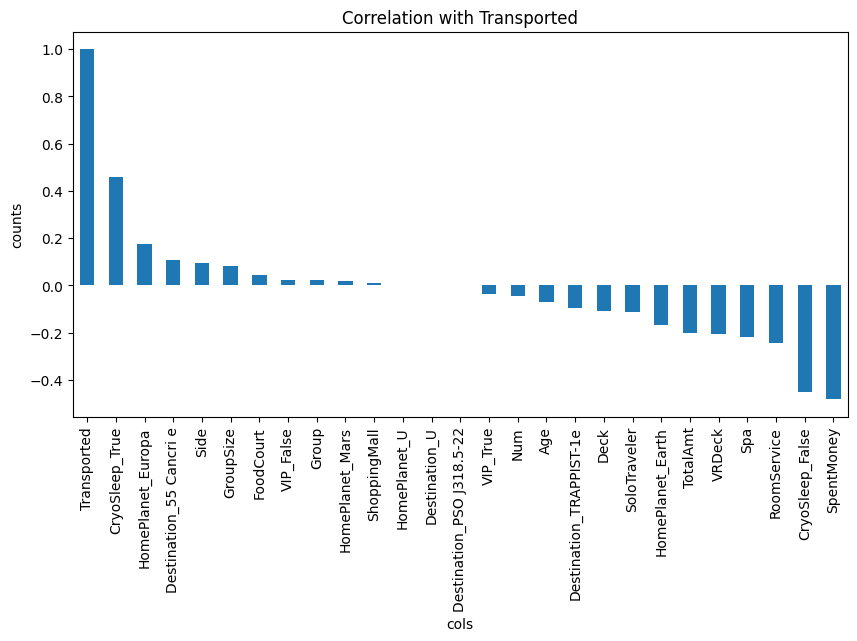

In [ ]:
plt.figure(figsize=(10,5))
df_train.corr()['Transported'].sort_values(ascending=False).plot(kind='bar')
my_save_plots("Correlation with Transported","cols", "counts",  "correlation_Transported_barplot")
plt.show()

In [ ]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(),
    "LightGBM": LGBMClassifier()
}

In [ ]:
accuracy_dict = {}

for name, model in models.items():
    if y_train.ndim > 1:
         y_train = y_train.ravel()

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracy_dict[name] = acc

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3512, number of negative: 3442
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001106 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1912
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505033 -> initscore=0.020133
[LightGBM] [Info] Start training from score 0.020133


In [ ]:
for i in accuracy_dict:
    print(f"{i}: {accuracy_dict[i]}")

print(f"maximum accuracy: {max(accuracy_dict.values())}")

Logistic Regression: 0.7883841288096607
Decision Tree: 0.7561817136285222
Random Forest: 0.8033352501437608
XGBoost: 0.8021851638872916
LightGBM: 0.8131109833237493
maximum accuracy: 0.8131109833237493


In [ ]:
best_model_name = max(accuracy_dict, key=accuracy_dict.get)
chosen_model = models[best_model_name]

pred = chosen_model.predict(df_test)

pred = chosen_model.predict(df_test)
final = pd.DataFrame()
final["PassengerId"] = original_test_passenger_id
final["Transported"] = pred
final.to_csv("submission.csv", index = False)

NameError: name 'accuracy_dict' is not defined

In [ ]:
# current score on kaggle is 79.869%